# 1. 데이터셋 살펴보기

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
CLASS_NAME_TO_ID = {'Bus': 0, 'Truck': 1}

In [ ]:
data_dir = '../../data/DRIVING-DATASET/Detection'
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
data_df

In [ ]:
# bounding box와 이미지 함께 살펴보기

# yolo boundingbox format = x_cen, y_cen, w, h

BOX_COLOR = {'Bus':(200, 0, 0), 'Truck':(0, 0, 200)}
CLASS_ID_TO_NAME = {0: 'Bus', 1: 'Truck'}

def visualize(img, bboxes, class_ids, color=BOX_COLOR, thickness=2):
    for bbox, class_id in zip(bboxes, class_ids):

        class_name = CLASS_ID_TO_NAME[class_id]
            
        x_cen, y_cen, w, h = bbox
        x_min = int(x_cen - w/2)
        y_min = int(y_cen - h/2)
        x_max = int(x_cen + w/2)
        y_max = int(y_cen + h/2)

        #boundin box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color = color[class_name], thickness= thickness)

        #class_name 표시
        ((text_w, text_h),_) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
        cv2.rectangle(img, (x_min, y_min - int(1.3 * text_h)), (x_min + text_w, y_min), color[class_name], -1)
        cv2.putText(
            img,
            text=class_name,
            org=(x_min, y_min - int(0.3 * text_h)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.35, 
            color=(255,255,255), 
            lineType=cv2.LINE_AA,
        )

        return img
        

In [ ]:
from ipywidgets import interact

In [ ]:
file_dir = '../../data/DRIVING-DATASET/Detection/images'
img_files = [fn for fn in os.listdir(file_dir) if fn.endswith('jpg')]

In [ ]:
@interact(index=(0, len(img_files)-1))
def show_imgbox(index=0):
    img_file = img_files[index]
    img_name = img_file.split('.')[0]
    img_df = data_df[data_df['ImageID']==img_name]
    class_names = img_df['LabelName'].values
    class_ids = [CLASS_NAME_TO_ID[class_name] for class_name in class_names]
    box = img_df[["XMin", "XMax", "YMin", "YMax"]].values
    
    img = cv2.imread(os.path.join(file_dir,img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_h, img_w, _ = img.shape
    
    yolo_box = box.copy()
    yolo_box[:, [0,1]] *= img_w
    yolo_box[:, [2,3]] *= img_h
    
    yolo_box[:, [1,2]] = yolo_box[:, [2,1]] # ["XMin", "XMax", "YMin", "YMax"] -> [XMin, YMin, XMax, YMax]
    
    yolo_box[:, 2:4] -= yolo_box[:, 0:2]
    yolo_box[:, 0:2] += (yolo_box[:, 2:4]/2)
    
    canvas = visualize(img, yolo_box, class_ids)
    
    plt.figure(figsize = (6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()


# 2. 데이터셋 및 데이터 로더 구축

In [ ]:
import torch

In [ ]:
class My_Dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
        self.phase = phase
        self.transformer = transformer

        self.img_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]

    def __len__(self):
        return len(img_files)

    def __getitem__(self, index):
    
        img, filename = self.get_img(index)
        bboxes, class_ids = self.get_label(filename)
        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        
        if self.transformer:
            transformed_data = self.transformer(image=img, bboxes=bboxes, class_ids = class_ids)
            img = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])
            
        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        
        return img, target, filename


    def get_img(self, index):
        filename = self.img_files[index]
        img = cv2.imread(os.path.join(data_dir, self.phase, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        return img, filename

    def get_label(self, filename):
        img_id = filename.split('.')[0]
        img_df = self.data_df[self.data_df['ImageID'] == img_id]
        class_names = img_df['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[class_name] for class_name in class_names])
        box = img_df[['XMin', 'YMin', 'XMax', 'YMax']].values

        bbox = box.copy()
        bbox[:,2:4] -= bbox[:, 0:2]
        bbox[:,0:2] += (bbox[:, 2:4]/2)

        return bbox, class_ids

In [ ]:
data_dir = '../../data/DRIVING-DATASET/Detection'
dataset = My_Dataset(data_dir, 'train')

In [ ]:
img, target, filename = dataset[0]

In [ ]:
# 텐서 변환 모듈
# albumentations은 transforms 보다 boundingbox의 변환에 대해서 더 많은 기능을 가지고 있음
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
IMG_SIZE = 448 #04챕터의 FasterRCNN과 비교를 위함

# albumentations 사용시 노멀라이제이션 먼저 한 후 텐서로 변환해야함
transformer = A.Compose([
        A.Resize(height=IMG_SIZE, width=IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']), #박스에 대해서도 transformer됨  
)

In [ ]:
dataset = My_Dataset(data_dir, 'train', transformer)
dataset[0]

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# 데이터 로더
def collate_fn(batch):
    img_list = []
    target_list = []
    filename_list = []

    for a,b,c in batch:
        img_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(img_list, dim=0), target_list, filename_list

In [ ]:
data_dir = '../../data/DRIVING-DATASET/Detection/'
BATCH_SIZE = 6

trainset = My_Dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [ ]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    print(images.shape,len(targets), len(filenames))
    
    if index == 0:
        break


In [ ]:
def build_dataloader(data_dir, transformer, batch_size=4):
    dataloaders = {}

    train_dataset = My_Dataset(data_dir, 'train', transformer)
    val_dataset = My_Dataset(data_dir, 'val', transformer)

    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn)
    dataloaders['val'] = DataLoader(val_dataset, batch_size = 1, shuffle=False, collate_fn = collate_fn)

    return dataloaders

In [ ]:
dataloaders = build_dataloader(data_dir, transformer, 4)

for index, batch in enumerate(dataloaders['train']):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

   
    print(images.shape,len(targets), len(filenames))
    
    if index == 0:
        break

In [ ]:
for phase in ["train", "val"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(images.shape,len(targets), len(filenames))
        
        if index == 0:
            break

# 3.YOLO v1 아키텍쳐 구현

- 그리드, 쉘 방식으로 앵커박스가 존재하지 않음
- 448,448의 이미지가 conv를 통과해서 depth (1+4)*2+classnum에 해당하는 feature map으로 변경

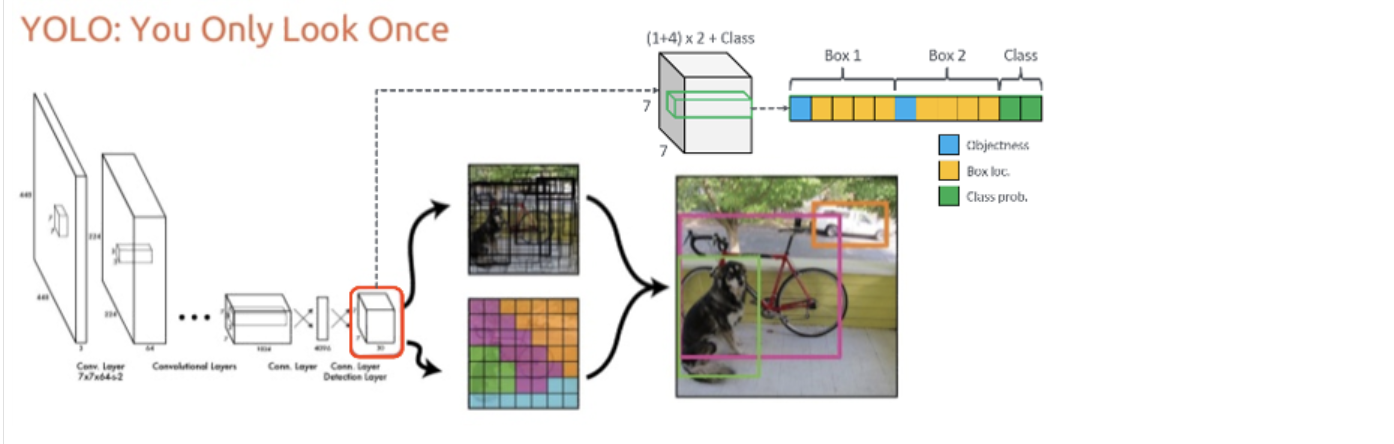

In [ ]:
import torchvision 
import torch.nn as nn

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18
#resnet18의 layer4까지 사용

In [ ]:
#layer4까지 통과한 shape확인
layer = [m for m in resnet18.children()]
model = nn.Sequential(*layer[:-2])

input = torch.rand(1,3,448,448)

output = model(input)

print(output.shape)

In [ ]:
#resnet을 backbone으로 사용
class YOLOv1(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        #init내부에서만 사용할 변수들(self필요없음)
        num_classes = num_classes
        num_boxes = 2
        grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained=True)
        layer = [m for m in resnet18.children()] #resnet의 일부분만 사용하기 위함, 리스트로 받아오는것이 레이어 조절에 유용

        self.backbone = nn.Sequential(*layer[:-2]) #맨 뒤의 두 레이어는 제외

        self.neck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0,bias=False), #backbone의 마지막 outputchannel이 512
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        #conv를 통과한 마지막 featuremap의 shape을 맞춰주는 역할 (batch, (4+1)*num_bboxes+num_classes, 7,7)
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_boxes+num_classes, kernel_size=1, padding=0, bias=False),
            nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size)) #(7,7)
        )

    def forward(self,x):
        out = self.backbone(x)
        out = self.neck(out)
        out = self.head(out)
        return out

        

In [ ]:
# test
NUM_CLASSES = 2
model = YOLOv1(num_classes=NUM_CLASSES)

x = torch.randn(1,3,448,448)
y = model(x)

y.shape

In [ ]:
BATCH_SIZE = 2
data_dir = '../../data/DRIVING-DATASET/Detection/'

trainset = My_Dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = YOLOv1(num_classes=NUM_CLASSES)

for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    print(images.shape)
    
    predictions = model(images)
    print(predictions.shape)
    
    if index == 0:
        break